In [1]:
%matplotlib inline



Transfer Learning Tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(450),
        transforms.Resize(size=(224,224)),
        #transforms.RandomResizedCrop(224),
        #transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(90),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #transforms.Normalize([0.7631, 0.5474, 0.5717], [0.0369, 0.0466, 0.0506])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(450),
        transforms.Resize(size=(224,224)),
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #transforms.Normalize([0.7631, 0.5474, 0.5717], [0.0369, 0.0466, 0.0506])
    ]),
}

data_dir = 'lesion_data_binary'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



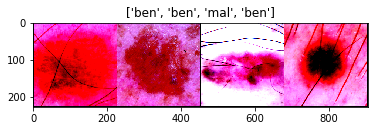

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    mean = np.array([0.7631, 0.5474, 0.5717])
    
    #std = np.array([0.229, 0.224, 0.225])
    std = np.array([0.0369, 0.0466, 0.0506])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [7]:
#softmax for converting result into probabilities
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
def get_results (predictions):
    df = pd.read_csv('HAM10000_metadata.csv')
    val_ids = pd.read_csv('val_split_info.csv')
    df['malignant'] = pd.DataFrame((df['dx'] == 'akiec') | (df['dx'] == 'mel') | (df['dx'] == 'bcc'))
    df['validation'] = df['image_id'].isin(val_ids['image'].values).values
    df = df.sort_values(by = 'image_id')

    df_test = df[df['validation'] == 1]
    y_test = pd.DataFrame(df_test['malignant']==1)
    
    confusion = confusion_matrix(y_test,predictions)
    print(confusion)
    
    
    # classification metrics (https://stackoverflow.com/a/43331484/8614827)
    FP = confusion.sum(axis=0) - np.diag(confusion)  
    FN = confusion.sum(axis=1) - np.diag(confusion)
    TP = np.diag(confusion)
    TN = confusion.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    # metrics used on MTEC website
    print(ACC.mean()) #accuracy
    print(TPR.mean()) #sensitivity
    print(TNR.mean()) #specificity
    print(metrics.f1_score(y_test, predictions, average=None).mean()) #F1-score

    

In [11]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


In [26]:
def test_model(model, data_transforms, phase):
    
    data_path = 'lesion_data_binary/'+phase



    train_dataset = ImageFolderWithPaths(
        root=data_path,
        transform=data_transforms
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset,batch_size=4, shuffle=False, num_workers=4
    )


    probabs = pd.DataFrame()
    names = pd.DataFrame()

    running_corrects =0.0
  

    for inputs, labels, paths in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)


        outputs = model_conv(inputs)
        _, preds = torch.max(outputs, 1)
        # add probabilities to DataFrame
        for element in range (inputs.size(0)):
            probabs = probabs.append(pd.Series(np.apply_along_axis(softmax, 1, outputs.detach().cpu().numpy())[element]),ignore_index=True)
            names =names.append([paths[element].replace('lesion_data_binary/val/mal/','').replace('.jpg','').replace('lesion_data_binary/val/ben/','')])

        running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / dataset_sizes['val']
    print(' Acc: {:.4f}'.format(acc))

        
    probabs.columns = ['ben','mal']
    names = names.reset_index().drop(['index'],axis=1)
    probabs['image'] = names
    probabs = probabs.sort_values(by='image')
    probabs = probabs.reset_index()
    
    return probabs
    

In [27]:
def evaluate_model (probabs):
    classes = probabs[['ben','mal']]
    classes.columns = [False,True]
    predictions = classes.idxmax(axis=1)
    get_results(predictions)
    

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [129]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4608 Acc: 0.8017
val Loss: 0.3692 Acc: 0.8363

Epoch 1/24
----------
train Loss: 0.4178 Acc: 0.8238
val Loss: 0.5929 Acc: 0.7487

Epoch 2/24
----------
train Loss: 0.3875 Acc: 0.8324
val Loss: 0.4082 Acc: 0.8391

Epoch 3/24
----------
train Loss: 0.3594 Acc: 0.8458
val Loss: 0.3611 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.3625 Acc: 0.8449
val Loss: 0.3821 Acc: 0.8455

Epoch 5/24
----------
train Loss: 0.3376 Acc: 0.8490
val Loss: 0.3526 Acc: 0.8630

Epoch 6/24
----------
train Loss: 0.3275 Acc: 0.8534
val Loss: 0.3426 Acc: 0.8638

Epoch 7/24
----------
train Loss: 0.2862 Acc: 0.8701
val Loss: 0.3235 Acc: 0.8682

Epoch 8/24
----------
train Loss: 0.2698 Acc: 0.8753
val Loss: 0.3339 Acc: 0.8690

Epoch 9/24
----------
train Loss: 0.2731 Acc: 0.8741
val Loss: 0.3267 Acc: 0.8646

Epoch 10/24
----------
train Loss: 0.2737 Acc: 0.8747
val Loss: 0.3258 Acc: 0.8690

Epoch 11/24
----------
train Loss: 0.2596 Acc: 0.8814
val Loss: 0.3348 Acc: 0.8694

Ep

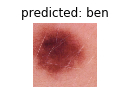

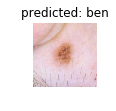

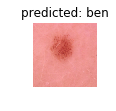

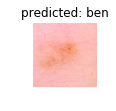

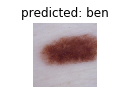

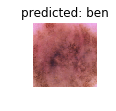

In [19]:
visualize_model(model_ft)

In [47]:
probabs = test_model(model_conv,data_transforms['val']'val')

In [49]:
evaluate_model(probabs)

[[1701  317]
 [ 403   90]]
0.7132616487455197
0.51273477847446
0.51273477847446
0.5126637554585153


ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [29]:
#model_conv = torchvision.models.resnet18(pretrained=True)
model_conv = torchvision.models.resnet152(pretrained=True)


for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
#optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.0001)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [30]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.4168 Acc: 0.8101
val Loss: 0.3938 Acc: 0.8303

Epoch 1/9
----------
train Loss: 0.3819 Acc: 0.8238
val Loss: 0.3944 Acc: 0.8268

Epoch 2/9
----------
train Loss: 0.3726 Acc: 0.8309
val Loss: 0.3667 Acc: 0.8367

Epoch 3/9
----------
train Loss: 0.3722 Acc: 0.8329
val Loss: 0.4219 Acc: 0.8212

Epoch 4/9
----------
train Loss: 0.3705 Acc: 0.8340
val Loss: 0.3946 Acc: 0.8192

Epoch 5/9
----------
train Loss: 0.3712 Acc: 0.8300
val Loss: 0.4036 Acc: 0.8288

Epoch 6/9
----------
train Loss: 0.3654 Acc: 0.8346
val Loss: 0.3755 Acc: 0.8399

Epoch 7/9
----------
train Loss: 0.3631 Acc: 0.8326
val Loss: 0.3908 Acc: 0.8140

Epoch 8/9
----------
train Loss: 0.3674 Acc: 0.8332
val Loss: 0.3954 Acc: 0.8292

Epoch 9/9
----------
train Loss: 0.3626 Acc: 0.8317
val Loss: 0.3961 Acc: 0.8343

Training complete in 36m 34s
Best val Acc: 0.839904


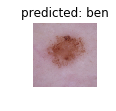

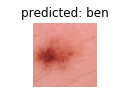

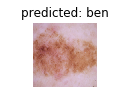

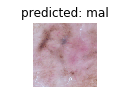

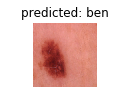

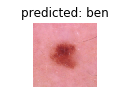

In [52]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
probabs = test_model(model_conv,data_transforms['val'],'val')

In [ ]:
probabs.to_csv('binary_classification', index=False)

In [28]:
evaluate_model(probabs)

[[1992   26]
 [ 447   46]]
0.8116288331342095
0.540211122212461
0.540211122212461
0.5283533310433424
